### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: 1st page is empty

Current solution: Explicitly define page number

### Import Dump

In [211]:
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

### Scanning

First we convert the pdf into a png per page

In [212]:
pdf_name = "pajak.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    name = pdf_name[:-4] + ".png"
    pix.save(name)

Read the images to be put into an Image object in cv2

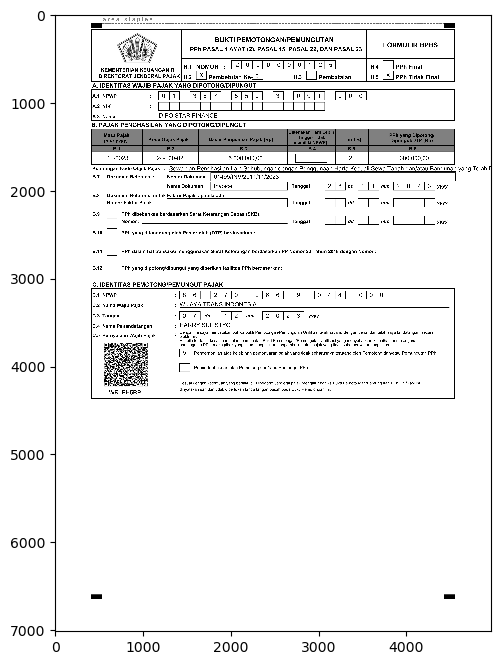

In [213]:
page_name = pdf_name[:-4] + ".png"

# read png
page = cv2.imread(page_name)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

The height crop in this image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

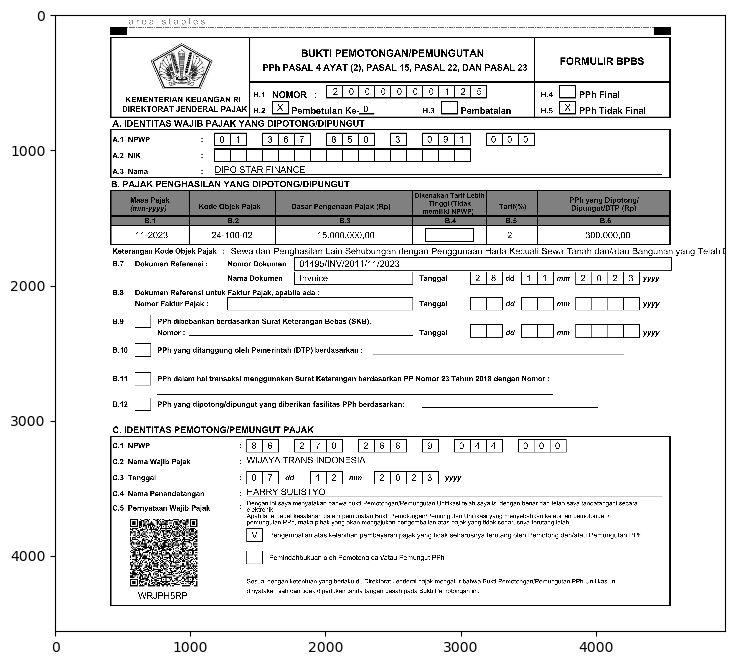

In [214]:
# get page height
page_height = page.shape[0]

# crop to only table
page = page[:int(page_height * 0.65), :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

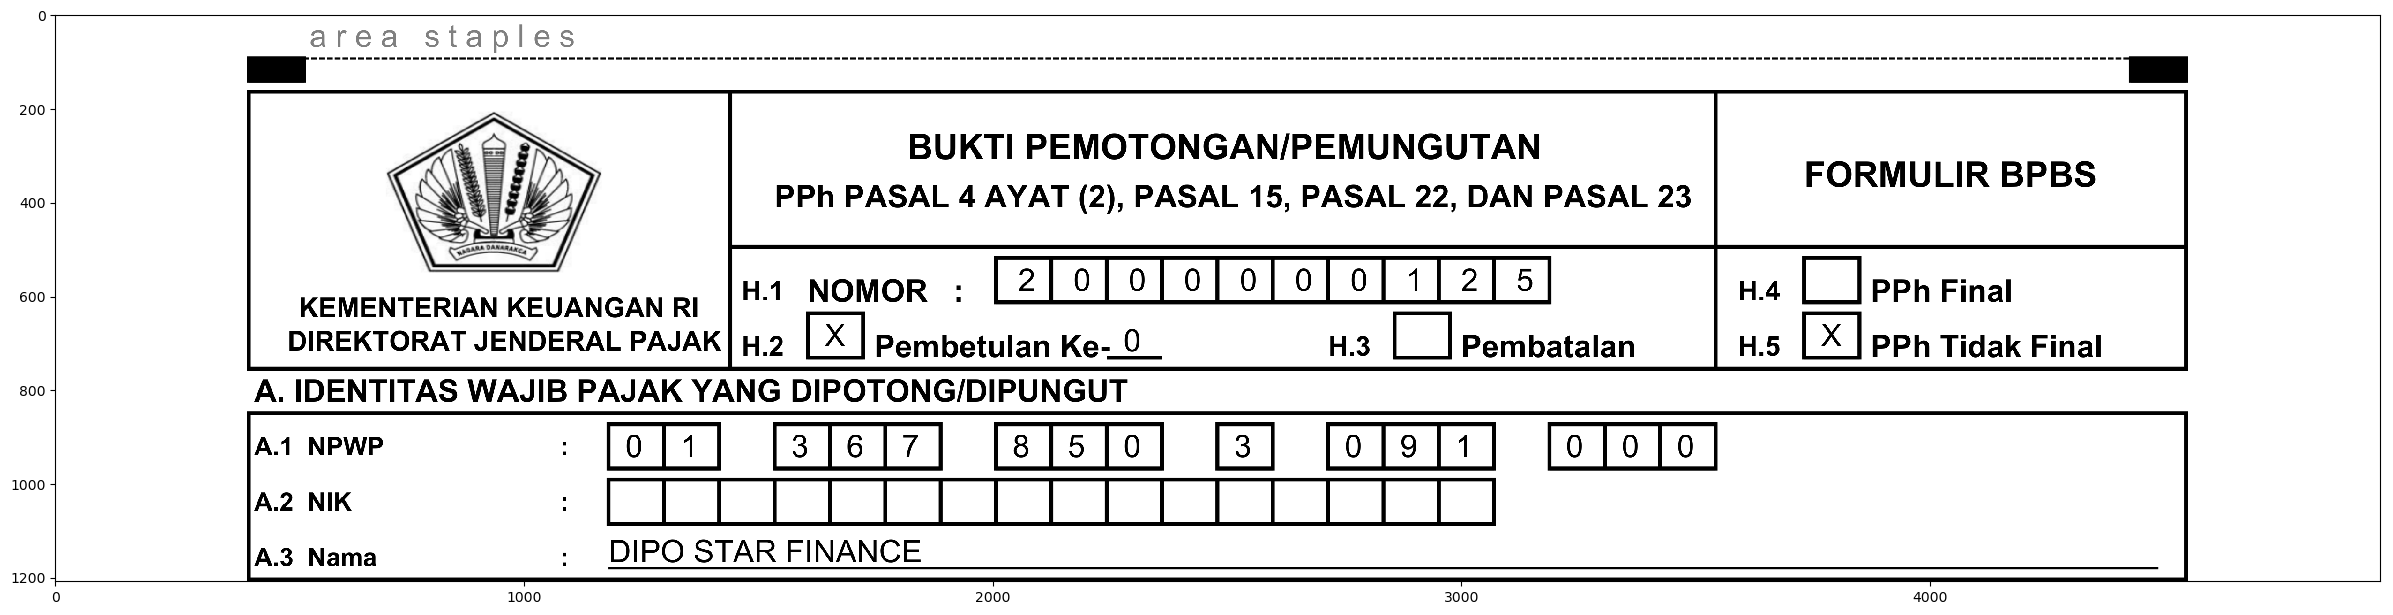

In [215]:
page_height = page.shape[0]

c1 = page[:int(page_height * 0.265), :]
c2 = page[int(page_height * 0.265):int(page_height * 0.66), :]
c3 = page[int(page_height * 0.66):, :]

plt.figure(figsize=(30, 8))
plt.imshow(c1, cmap="gray")

In [216]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

vals = []

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


c:\Users\paoma\miniconda3\lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


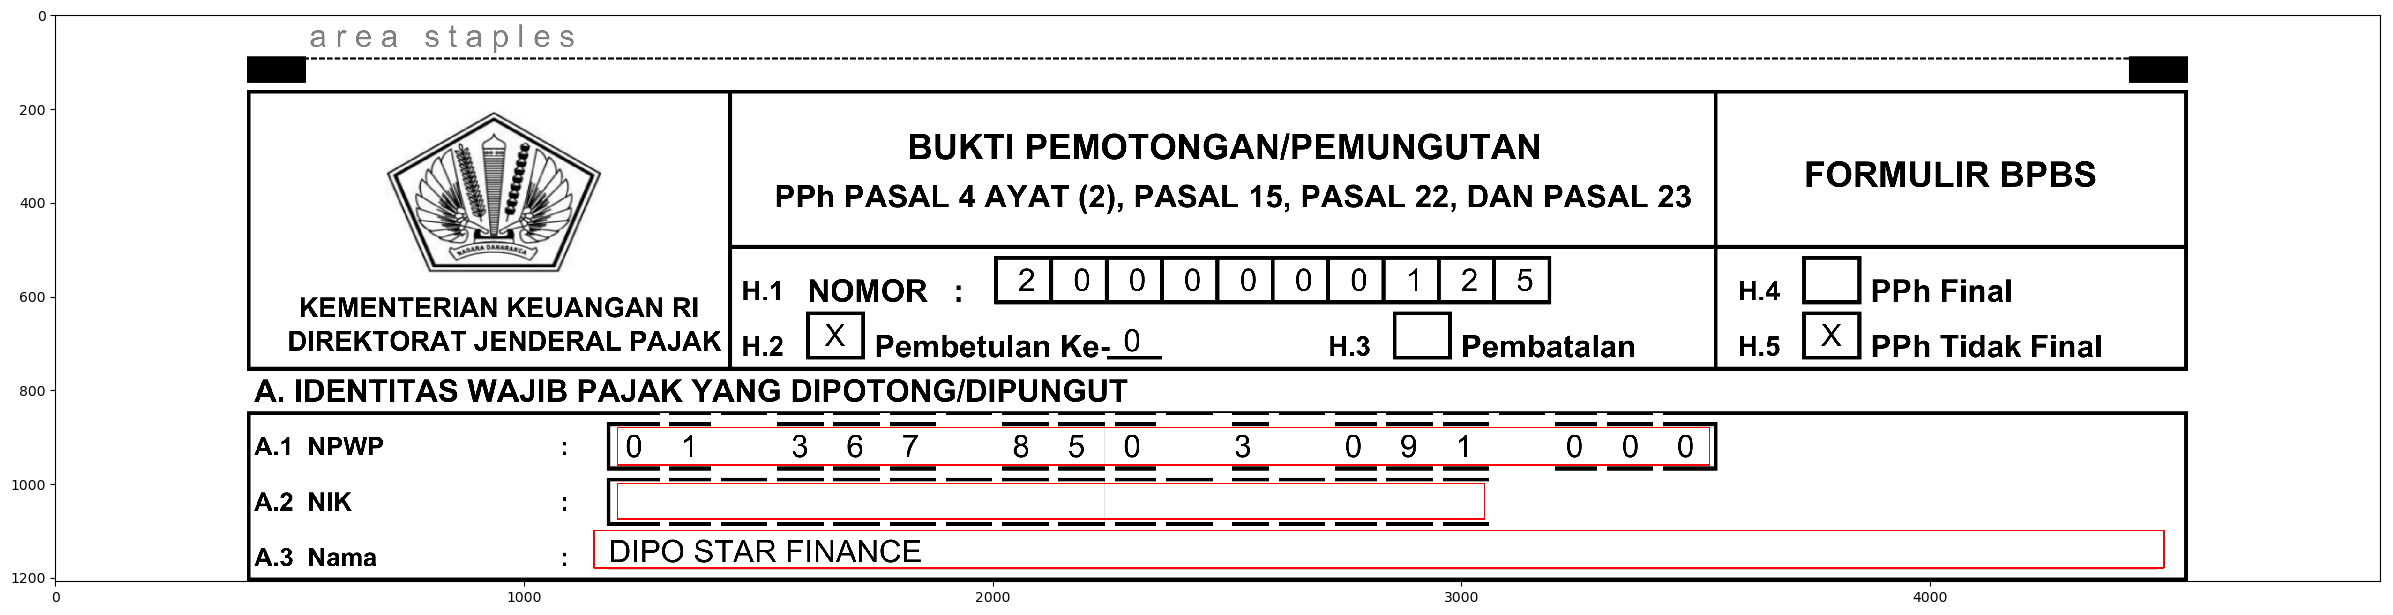

In [217]:
c1_copy = c1.copy()

# x1, x2, y1, y2
whites = [(1290, 1310, 850, 1090),
          (1400, 1420, 850, 1090),
          (1520, 1540, 850, 1090),
          (1640, 1660, 850, 1090),
          (1760, 1780, 850, 1090),
          (1880, 1900, 850, 1090),
          (2000, 2020, 850, 1090),
          (2120, 2140, 850, 1090),
          (2240, 2260, 850, 1090),
          (2350, 2370, 850, 1090),
          (2470, 2490, 850, 1090),
          (2490, 2510, 850, 1090),
          (2590, 2610, 850, 1090),
          (2710, 2730, 850, 1090),
          (2820, 2840, 850, 1090),
          (2940, 2960, 850, 1090),
          (3060, 3080, 850, 1090),
          (3180, 3200, 850, 1090),
          (3290, 3310, 850, 1090),
          (3410, 3430, 850, 1090)]

rois = [(1200, 3530, 880, 960),
        (1200, 3050, 1000, 1075),
        (1150, 4500, 1100, 1180)]

for w in whites:
    cv2.rectangle(c1_copy, (w[0], w[2]), (w[1], w[3]), (255, 255, 255), -1)

for r in rois:
    pixel_values = processor(images=c1_copy[r[2]:r[3],r[0]:r[1]], return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    vals.append(generated_text)

    cv2.rectangle(c1_copy, (r[0], r[2]), (r[1], r[3]), (255, 0, 0), 2)

plt.figure(figsize=(30, 8))
plt.imshow(c1_copy, cmap="gray")

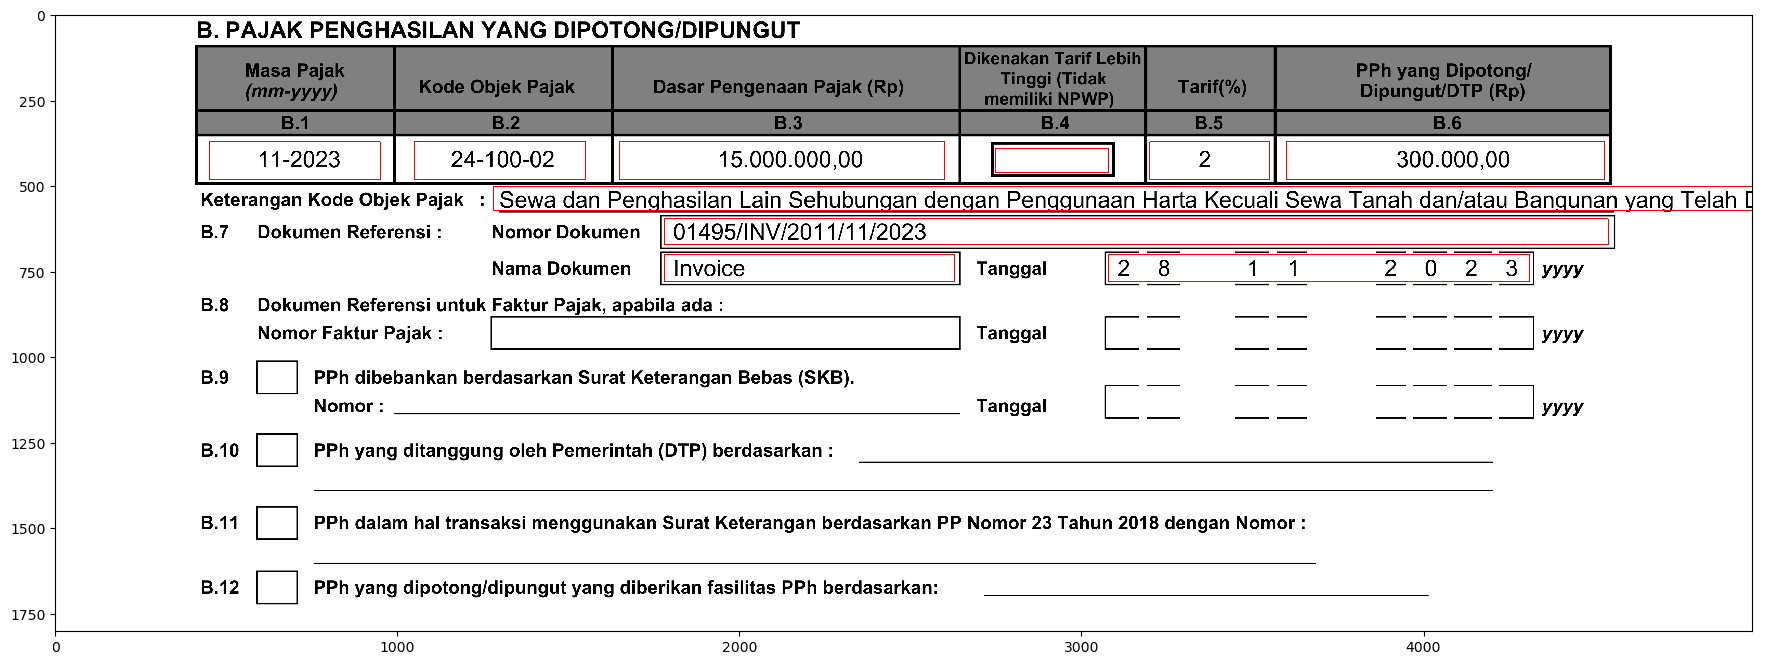

In [218]:
c2_copy = c2.copy()

# x1, x2, y1, y2
whites = [(3170, 3190, 690, 1180),
          (3290, 3450, 690, 1180),
          (3550, 3570, 690, 1180),
          (3660, 3860, 690, 1180),
          (3950, 3970, 690, 1180),
          (4070, 4090, 690, 1180),
          (4200, 4220, 690, 1180)]

rois = [(450, 950, 370, 480),
        (1050, 1550, 370, 480),
        (1650, 2600, 370, 480),
        (2750, 3080, 390, 460),
        (3200, 3550, 370, 480),
        (3600, 4530, 370, 480),
        (1280, c2_copy.shape[1], 500, 570),
        (1780, 4540, 595, 670),
        (1780, 2630, 700, 780),
        (3080, 4310, 700, 780)]

for w in whites:
    cv2.rectangle(c2_copy, (w[0], w[2]), (w[1], w[3]), (255, 255, 255), -1)

for r in rois:
    pixel_values = processor(images=c2_copy[r[2]:r[3],r[0]:r[1]], return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    vals.append(generated_text)

    cv2.rectangle(c2_copy, (r[0], r[2]), (r[1], r[3]), (255, 0, 0), 2)


plt.figure(figsize=(30, 8))
plt.imshow(c2_copy)

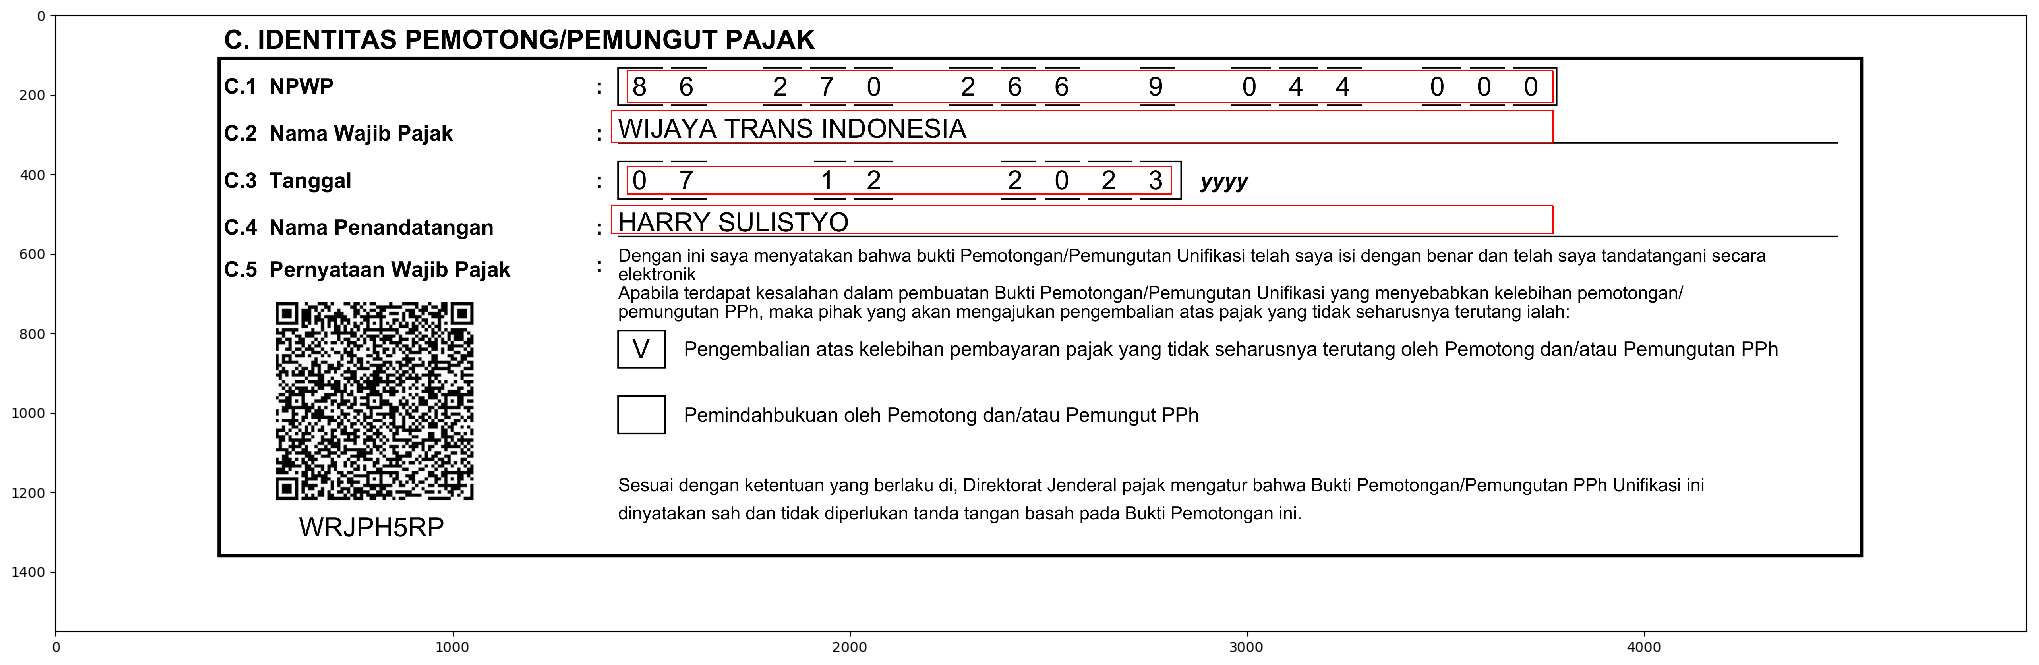

In [219]:
c3_copy = c3.copy()

# x1, x2, y1, y2
whites = [(1530, 1550, 130, 230),
          (1530, 1550, 360, 470),
          (1640, 1780, 130, 230),
          (1640, 1910, 360, 470),
          (1880, 1900, 130, 230),
          (1990, 2010, 130, 230),
          (1990, 2010, 360, 470),
          (2110, 2250, 130, 230),
          (2110, 2380, 360, 470),
          (2360, 2380, 130, 230),
          (2470, 2490, 130, 230),
          (2470, 2490, 360, 470),
          (2580, 2730, 130, 230),
          (2580, 2600, 360, 470),
          (2710, 2730, 360, 470),
          (2820, 2960, 130, 230),
          (3060, 3080, 130, 230),
          (3180, 3200, 130, 230),
          (3290, 3440, 130, 230),
          (3540, 3560, 130, 230),
          (3650, 3670, 130, 230)]

rois = [(1440, 3770, 140, 220),
        (1400, 3770, 240, 320),
        (1440, 2810, 380, 450),
        (1400, 3770, 480, 550)]

for w in whites:
    cv2.rectangle(c3_copy, (w[0], w[2]), (w[1], w[3]), (255, 255, 255), -1)

for r in rois:
    pixel_values = processor(images=c3_copy[r[2]:r[3],r[0]:r[1]], return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    vals.append(generated_text)


    cv2.rectangle(c3_copy, (r[0], r[2]), (r[1], r[3]), (255, 0, 0), 2)


plt.figure(figsize=(30, 8))
plt.imshow(c3_copy)

In [220]:
vals

['01 367 850 3 091 000',
 'SR: 01/02/2018 12:03:42:02:42',
 'DPOSTARENCE OF RECEIPT FOR AN OFFER',
 '11-2023',
 '24-100-02',
 '15.000.000,00',
 '1',
 '2',
 '300.000.00',
 'SEKA CAN PENGHSIAN LAIN SEHUBUNEN BENGAN PERP',
 '0149:IN/201/11/2013',
 'INVOICE',
 '2 8 1 1 2 0 2 3',
 '86 270 266 9 044 000',
 'WIJAYA TRANS INDONESIA',
 '07 122 20 23',
 'HARRYSULISTYO FOOD US ON BACK']